In [1]:
!unzip -o data.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Phân Tích Mối Quan Hệ Giữa Thời Tiết và Chất Lượng Không Khí

## Đề Tài: Dự Đoán Chất Lượng Không Khí Dựa Trên Các Chỉ Số Thời Tiết

### Mục Tiêu

Notebook này thực hiện phân tích khám phá dữ liệu (EDA) để hiểu rõ mối quan hệ giữa các yếu tố khí tượng và chất lượng không khí tại ba thành phố Việt Nam:

- **Cần Thơ (CT)**: Đại diện vùng đồng bằng sông Cửu Long
- **Thành phố Hồ Chí Minh (HCM)**: Đại diện đô thị lớn phía Nam
- **Hà Nội (HN)**: Đại diện thủ đô phía Bắc

### Câu Hỏi Nghiên Cứu

1. Các chỉ số thời tiết nào có ảnh hưởng mạnh nhất đến chất lượng không khí?
2. Có sự khác biệt về chất lượng không khí giữa các thành phố không?
3. Biến động theo thời gian (mùa, ngày/đêm) ảnh hưởng như thế nào?
4. Mối quan hệ phi tuyến giữa thời tiết và ô nhiễm ra sao?

### Dữ Liệu

- **Nguồn**: File CSV đã xử lý (_v4.csv)
- **Thời gian**: 2023-01-01 đến 2025-12-01 (25,561 quan sát theo giờ)
- **Biến số**: 18 đặc trưng (7 chỉ số không khí + 11 chỉ số thời tiết)

---

## 1. Khai Báo Thư Viện và Cấu Hình

In [2]:
%pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cài đặt thư viện bị thiếu


# Thư viện xử lý dữ liệu
import numpy as np
import pandas as pd
from datetime import datetime

# Thư viện trực quan hóa
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from windrose import WindroseAxes

# Thư viện phân tích thống kê
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Cấu hình hiển thị
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("husl")
sns.set_style("whitegrid")

%matplotlib inline

# Tắt cảnh báo
import warnings
warnings.filterwarnings('ignore')

print("Đã import thành công các thư viện!")

Đã import thành công các thư viện!


---

## 2. Tải và Khám Phá Dữ Liệu

### 2.1. Tải Dữ Liệu Từ 3 Thành Phố

In [4]:
# Định nghĩa đường dẫn file
cities = {
    'Cần Thơ': 'data/cleaned_data_CT.csv',
    'TP Hồ Chí Minh': 'data/cleaned_data_HCM.csv',
    'Hà Nội': 'data/cleaned_data_HN.csv'
}

# Tải dữ liệu
data = {}
for city_name, file_path in cities.items():
    try:
        df = pd.read_csv(file_path, parse_dates=['timestamp_local'], index_col='timestamp_local')
        data[city_name] = df
        print(f"✓ {city_name}: {df.shape[0]:,} quan sát × {df.shape[1]} biến")
    except FileNotFoundError:
        print(f"✗ Không tìm thấy file: {file_path}")

print(f"\nĐã tải thành công dữ liệu từ {len(data)} thành phố!")

✓ Cần Thơ: 25,561 quan sát × 18 biến
✓ TP Hồ Chí Minh: 25,561 quan sát × 18 biến
✓ Hà Nội: 25,561 quan sát × 18 biến

Đã tải thành công dữ liệu từ 3 thành phố!


### 2.2. Tổng Quan Dữ Liệu

Hiển thị thông tin cơ bản và thống kê mô tả của từng thành phố.

In [5]:
for city_name, df in data.items():
    print(f"\n{'='*70}")
    print(f"THÀNH PHỐ: {city_name}")
    print(f"{'='*70}")
    print(f"\nKích thước: {df.shape}")
    print(f"Thời gian: {df.index.min()} đến {df.index.max()}")
    print(f"\nCác biến số:")
    print(df.columns.to_list())
    print(f"\nGiá trị thiếu: {df.isnull().sum().sum()} ({df.isnull().sum().sum() / df.size * 100:.2f}%)")


THÀNH PHỐ: Cần Thơ

Kích thước: (25561, 18)
Thời gian: 2023-01-01 00:00:00 đến 2025-12-01 00:00:00

Các biến số:
['aqi', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'rh', 'pres', 'wind_spd', 'wind_dir', 'clouds', 'precip', 'pod', 'dewpt', 'wind_sin', 'wind_cos']

Giá trị thiếu: 0 (0.00%)

THÀNH PHỐ: TP Hồ Chí Minh

Kích thước: (25561, 18)
Thời gian: 2023-01-01 00:00:00 đến 2025-12-01 00:00:00

Các biến số:
['aqi', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'rh', 'pres', 'wind_spd', 'wind_dir', 'clouds', 'precip', 'pod', 'dewpt', 'wind_sin', 'wind_cos']

Giá trị thiếu: 0 (0.00%)

THÀNH PHỐ: Hà Nội

Kích thước: (25561, 18)
Thời gian: 2023-01-01 00:00:00 đến 2025-12-01 00:00:00

Các biến số:
['aqi', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2', 'temp', 'rh', 'pres', 'wind_spd', 'wind_dir', 'clouds', 'precip', 'pod', 'dewpt', 'wind_sin', 'wind_cos']

Giá trị thiếu: 0 (0.00%)


In [6]:
# Thống kê mô tả cho một thành phố (ví dụ: Hà Nội)
city_sample = list(data.keys())[2] if data else None  #0:CT,1:TpHCM,2:HN

if city_sample:
    print(f"\nTHỐNG KÊ MÔ TẢ - {city_sample}")
    print("=" * 70)
    display(data[city_sample].describe().round(2))


THỐNG KÊ MÔ TẢ - Hà Nội


,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,wind_spd,wind_dir,clouds,precip,pod,dewpt,wind_sin,wind_cos
count,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00,25561.00
mean,122.29,634.11,32.62,52.66,69.74,49.68,62.14,25.17,78.46,1009.85,1.68,177.17,68.08,0.32,0.54,20.82,0.25,-0.13
std,57.69,947.44,35.58,43.82,70.29,40.15,62.31,5.48,14.99,7.41,0.85,99.09,31.86,1.15,0.50,5.97,0.60,0.75
min,4.00,0.00,1.00,0.00,1.00,1.00,0.00,7.00,17.00,983.00,0.00,0.00,0.00,0.00,0.00,-6.90,-1.00,-1.00
25%,80.00,125.90,12.30,21.70,34.00,25.00,17.70,21.30,69.00,1004.00,1.00,115.00,50.00,0.00,0.00,17.40,-0.17,-0.77
50%,110.00,217.50,20.50,40.70,52.20,39.00,52.50,26.00,83.00,1009.00,1.66,144.00,75.00,0.00,1.00,23.10,0.42,-0.37
75%,155.00,806.00,38.00,71.30,82.10,59.00,88.00,29.00,91.00,1016.00,2.00,255.00,96.00,0.00,1.00,25.40,0.75,0.69
max,500.00,15956.20,625.00,700.00,1103.00,457.00,721.00,40.00,100.00,1033.00,12.40,360.00,100.00,41.00,1.00,29.60,1.00,1.00


---

## 3. So Sánh Chất Lượng Không Khí Giữa Các Thành Phố

### 3.1. Biểu Đồ Boxplot So Sánh AQI

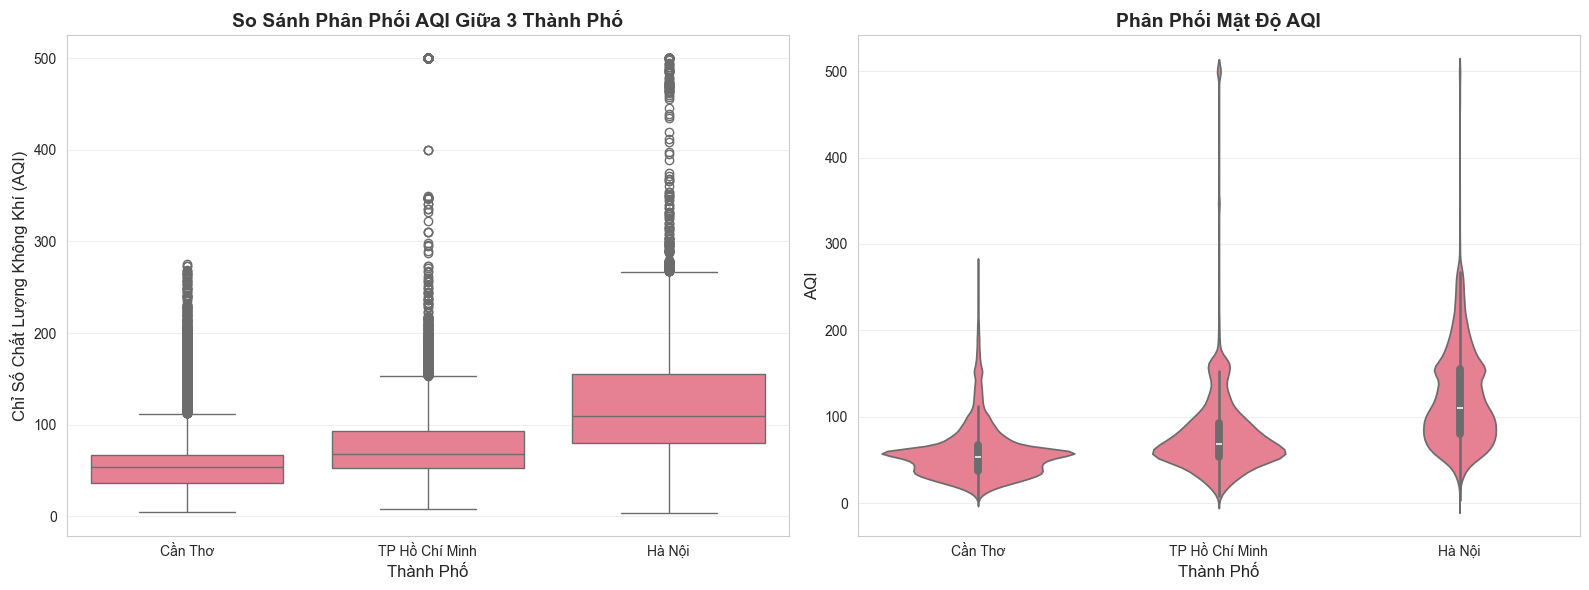


THỐNG KÊ AQI TRUNG BÌNH:
Cần Thơ             : 58.75 ± 31.56
TP Hồ Chí Minh      : 79.93 ± 52.12
Hà Nội              : 122.29 ± 57.69


In [7]:
# Chuẩn bị dữ liệu cho so sánh
aqi_data = []
for city_name, df in data.items():
    temp_df = df[['aqi']].copy()
    temp_df['Thành phố'] = city_name
    aqi_data.append(temp_df)

aqi_combined = pd.concat(aqi_data)

# Vẽ boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(data=aqi_combined, x='Thành phố', y='aqi', ax=axes[0])
axes[0].set_title('So Sánh Phân Phối AQI Giữa 3 Thành Phố', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Chỉ Số Chất Lượng Không Khí (AQI)', fontsize=12)
axes[0].set_xlabel('Thành Phố', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Violin plot
sns.violinplot(data=aqi_combined, x='Thành phố', y='aqi', ax=axes[1])
axes[1].set_title('Phân Phối Mật Độ AQI', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AQI', fontsize=12)
axes[1].set_xlabel('Thành Phố', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê so sánh
print("\nTHỐNG KÊ AQI TRUNG BÌNH:")
print("=" * 50)
for city_name, df in data.items():
    print(f"{city_name:20s}: {df['aqi'].mean():.2f} ± {df['aqi'].std():.2f}")

### 3.2. So Sánh Nồng Độ Các Chất Ô Nhiễm

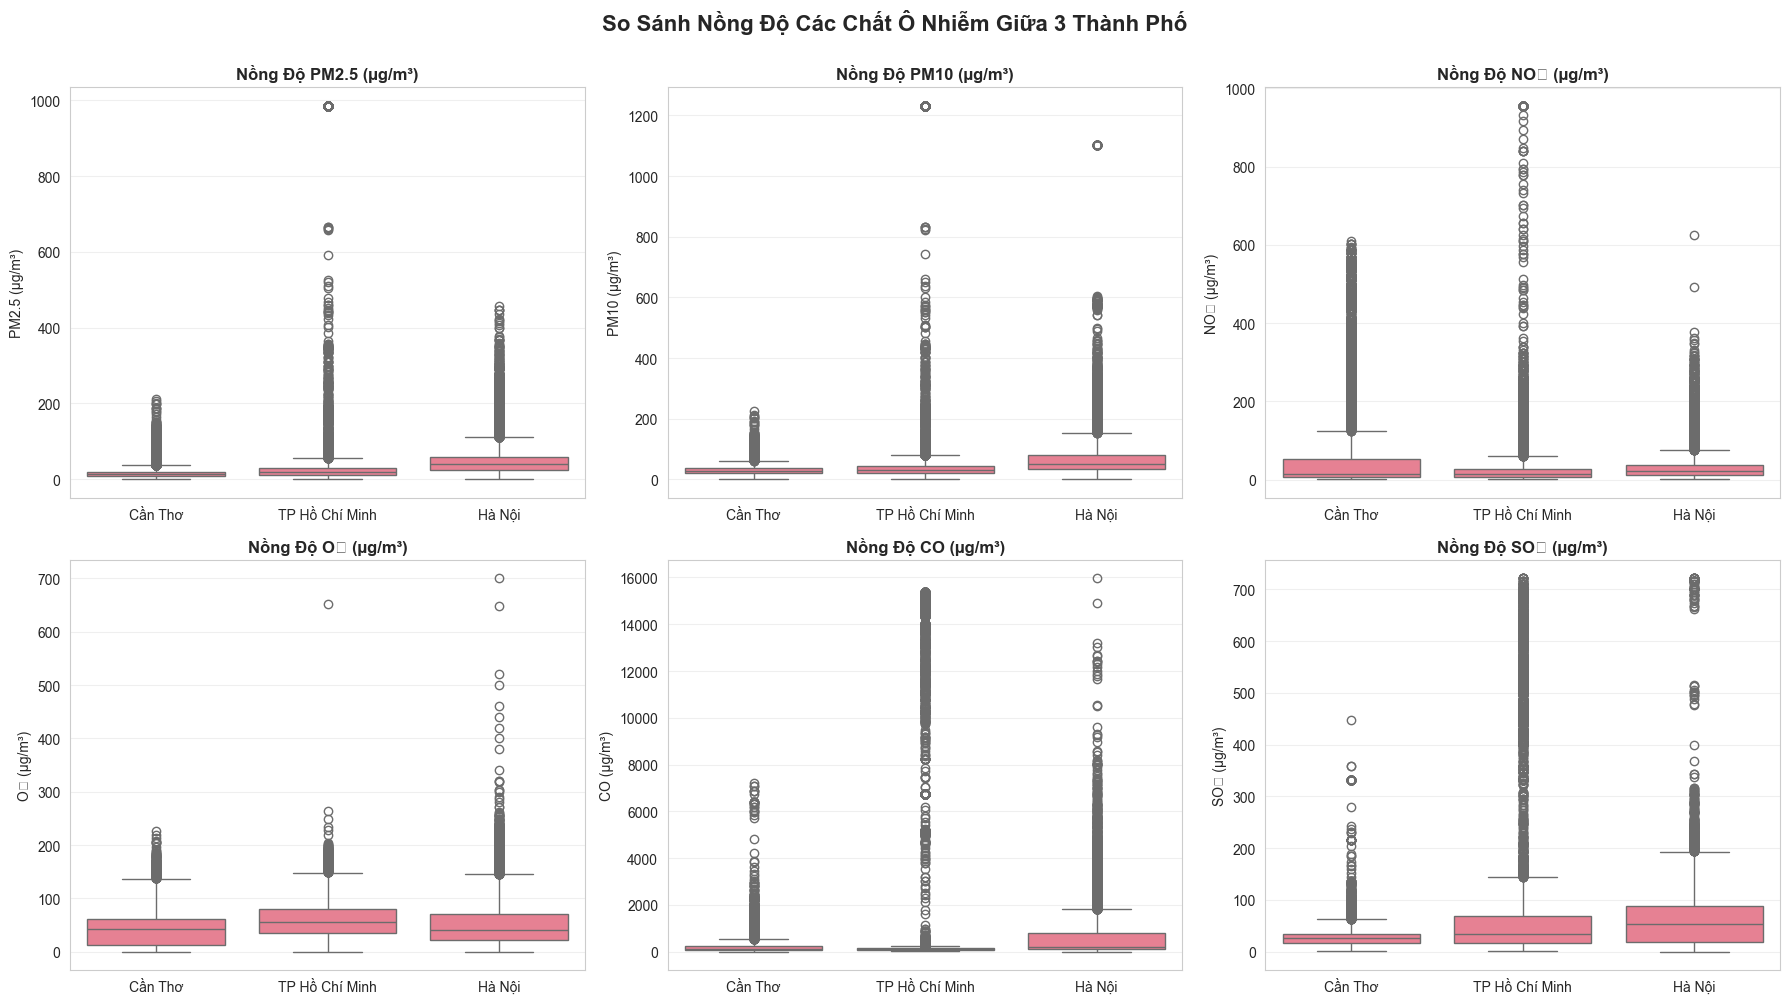

In [8]:
pollutants = ['pm25', 'pm10', 'no2', 'o3', 'co', 'so2']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, pollutant in enumerate(pollutants):
    # Chuẩn bị dữ liệu
    pollutant_data = []
    for city_name, df in data.items():
        temp_df = df[[pollutant]].copy()
        temp_df['Thành phố'] = city_name
        pollutant_data.append(temp_df)

    combined = pd.concat(pollutant_data)

    # Vẽ boxplot
    sns.boxplot(data=combined, x='Thành phố', y=pollutant, ax=axes[idx])

    # Định dạng
    pollutant_names = {
        'pm25': 'PM2.5 (µg/m³)',
        'pm10': 'PM10 (µg/m³)',
        'no2': 'NO₂ (µg/m³)',
        'o3': 'O₃ (µg/m³)',
        'co': 'CO (µg/m³)',
        'so2': 'SO₂ (µg/m³)'
    }
    axes[idx].set_title(f'Nồng Độ {pollutant_names[pollutant]}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(pollutant_names[pollutant], fontsize=10)
    axes[idx].set_xlabel('')
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('So Sánh Nồng Độ Các Chất Ô Nhiễm Giữa 3 Thành Phố',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

---

## 4. Phân Tích Tương Quan Giữa Thời Tiết và Chất Lượng Không Khí

### 4.1. Ma Trận Tương Quan

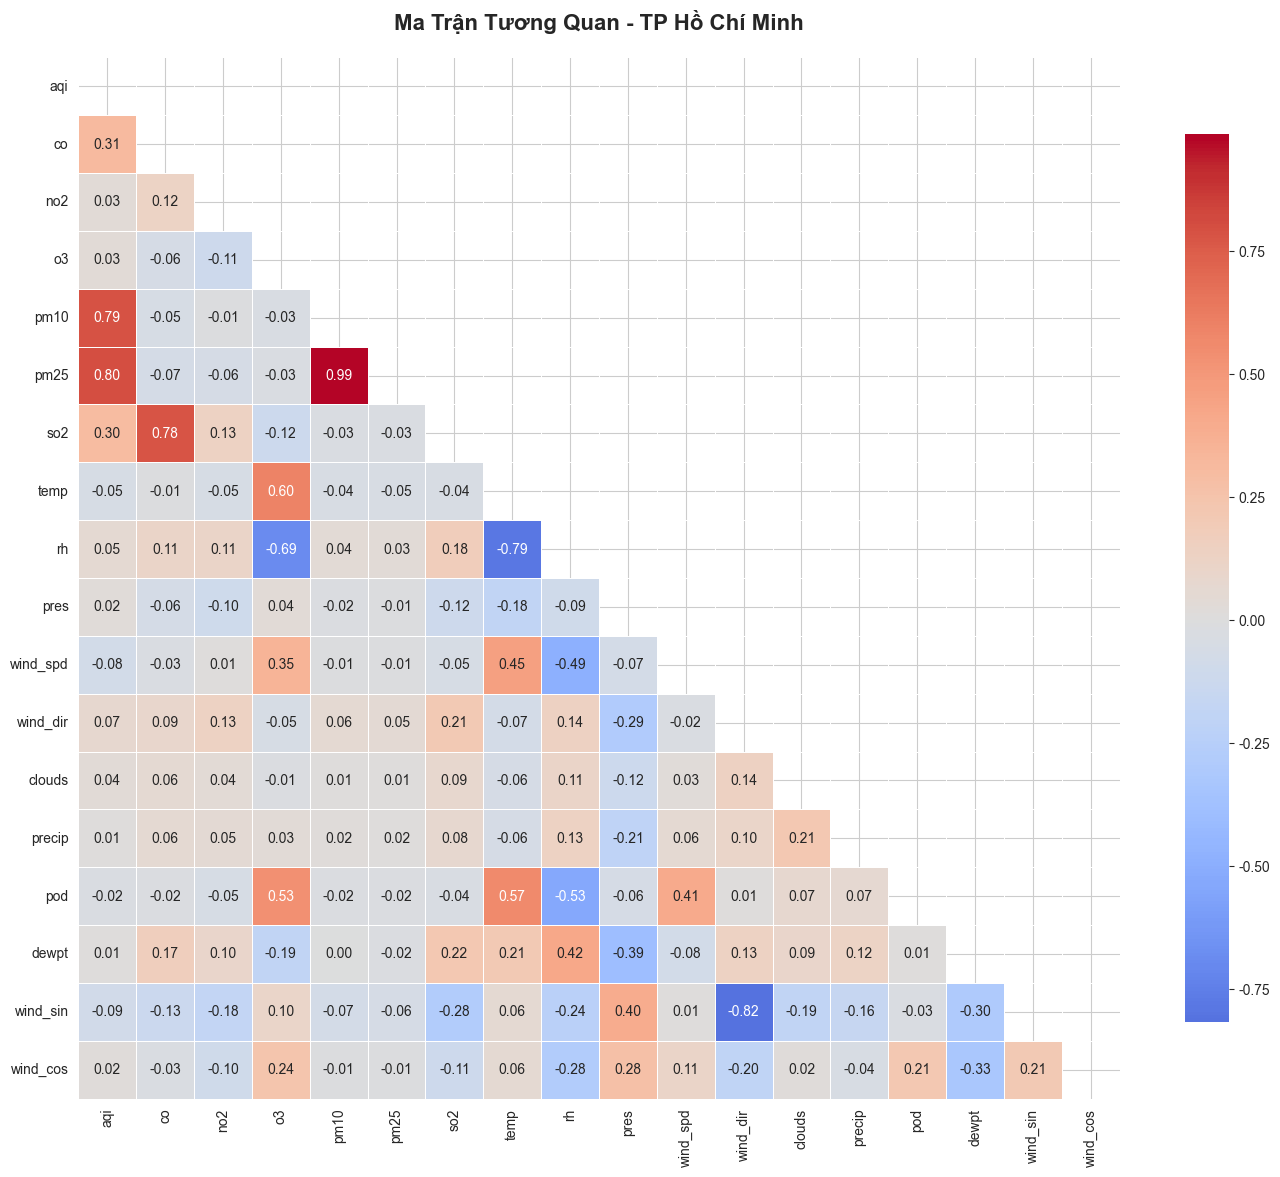


TOP 10 BIẾN TƯƠNG QUAN MẠNH NHẤT VỚI AQI (TP Hồ Chí Minh):
pm25           : +0.801
pm10           : +0.785
co             : +0.314
so2            : +0.301
wind_dir       : +0.074
rh             : +0.053
clouds         : +0.036
no2            : +0.031
o3             : +0.031
pres           : +0.023


In [9]:
# Chọn một thành phố để phân tích chi tiết (ví dụ: Hà Nội)
sample_city = list(data.keys())[1] if data else None

if sample_city:
    df_sample = data[sample_city]

    # Tính ma trận tương quan
    corr_matrix = df_sample.corr()

    # Vẽ heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True,
                linewidths=0.5, cbar_kws={"shrink": 0.8},
                ax=ax)

    ax.set_title(f'Ma Trận Tương Quan - {sample_city}',
                 fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    # In top 10 tương quan mạnh nhất với AQI
    print(f"\nTOP 10 BIẾN TƯƠNG QUAN MẠNH NHẤT VỚI AQI ({sample_city}):")
    print("=" * 60)
    aqi_corr = corr_matrix['aqi'].sort_values(ascending=False)
    for var, corr_val in aqi_corr.iloc[1:11].items():
        print(f"{var:15s}: {corr_val:+.3f}")

### 4.2. Mối Quan Hệ Giữa Các Chỉ Số Thời Tiết và AQI

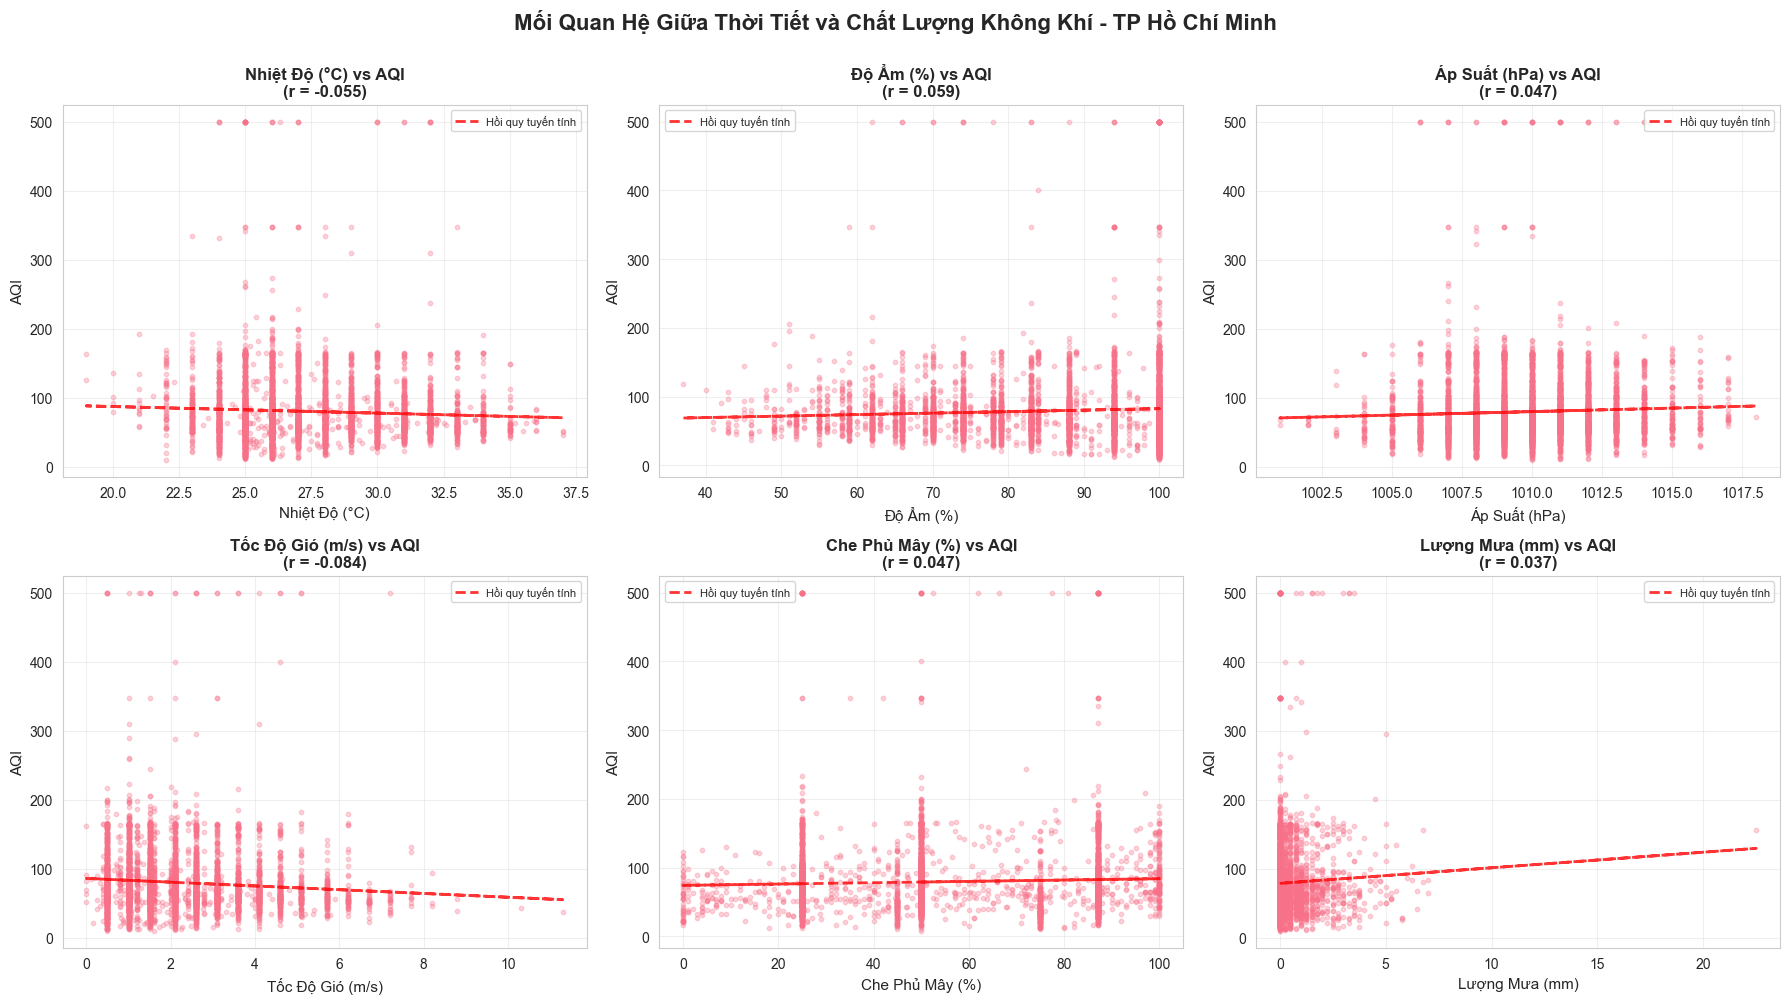

In [10]:
if sample_city:
    df_sample = data[sample_city]

    weather_vars = ['temp', 'rh', 'pres', 'wind_spd', 'clouds', 'precip']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    var_names = {
        'temp': 'Nhiệt Độ (°C)',
        'rh': 'Độ Ẩm (%)',
        'pres': 'Áp Suất (hPa)',
        'wind_spd': 'Tốc Độ Gió (m/s)',
        'clouds': 'Che Phủ Mây (%)',
        'precip': 'Lượng Mưa (mm)'
    }

    for idx, var in enumerate(weather_vars):
        # Lấy mẫu để vẽ nhanh hơn
        sample_size = min(5000, len(df_sample))
        sample_indices = np.random.choice(len(df_sample), sample_size, replace=False)

        x = df_sample[var].iloc[sample_indices]
        y = df_sample['aqi'].iloc[sample_indices]

        # Scatter plot
        axes[idx].scatter(x, y, alpha=0.3, s=10)

        # Thêm đường hồi quy
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        axes[idx].plot(x, p(x), "r--", alpha=0.8, linewidth=2, label='Hồi quy tuyến tính')

        # Tính hệ số tương quan
        corr, _ = pearsonr(x, y)

        axes[idx].set_xlabel(var_names[var], fontsize=11)
        axes[idx].set_ylabel('AQI', fontsize=11)
        axes[idx].set_title(f'{var_names[var]} vs AQI\n(r = {corr:.3f})',
                            fontsize=12, fontweight='bold')
        axes[idx].grid(alpha=0.3)
        axes[idx].legend(fontsize=8)

    plt.suptitle(f'Mối Quan Hệ Giữa Thời Tiết và Chất Lượng Không Khí - {sample_city}',
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

---

## 5. Phân Tích Xu Hướng Theo Thời Gian

### 5.1. Biến Động AQI Theo Tháng

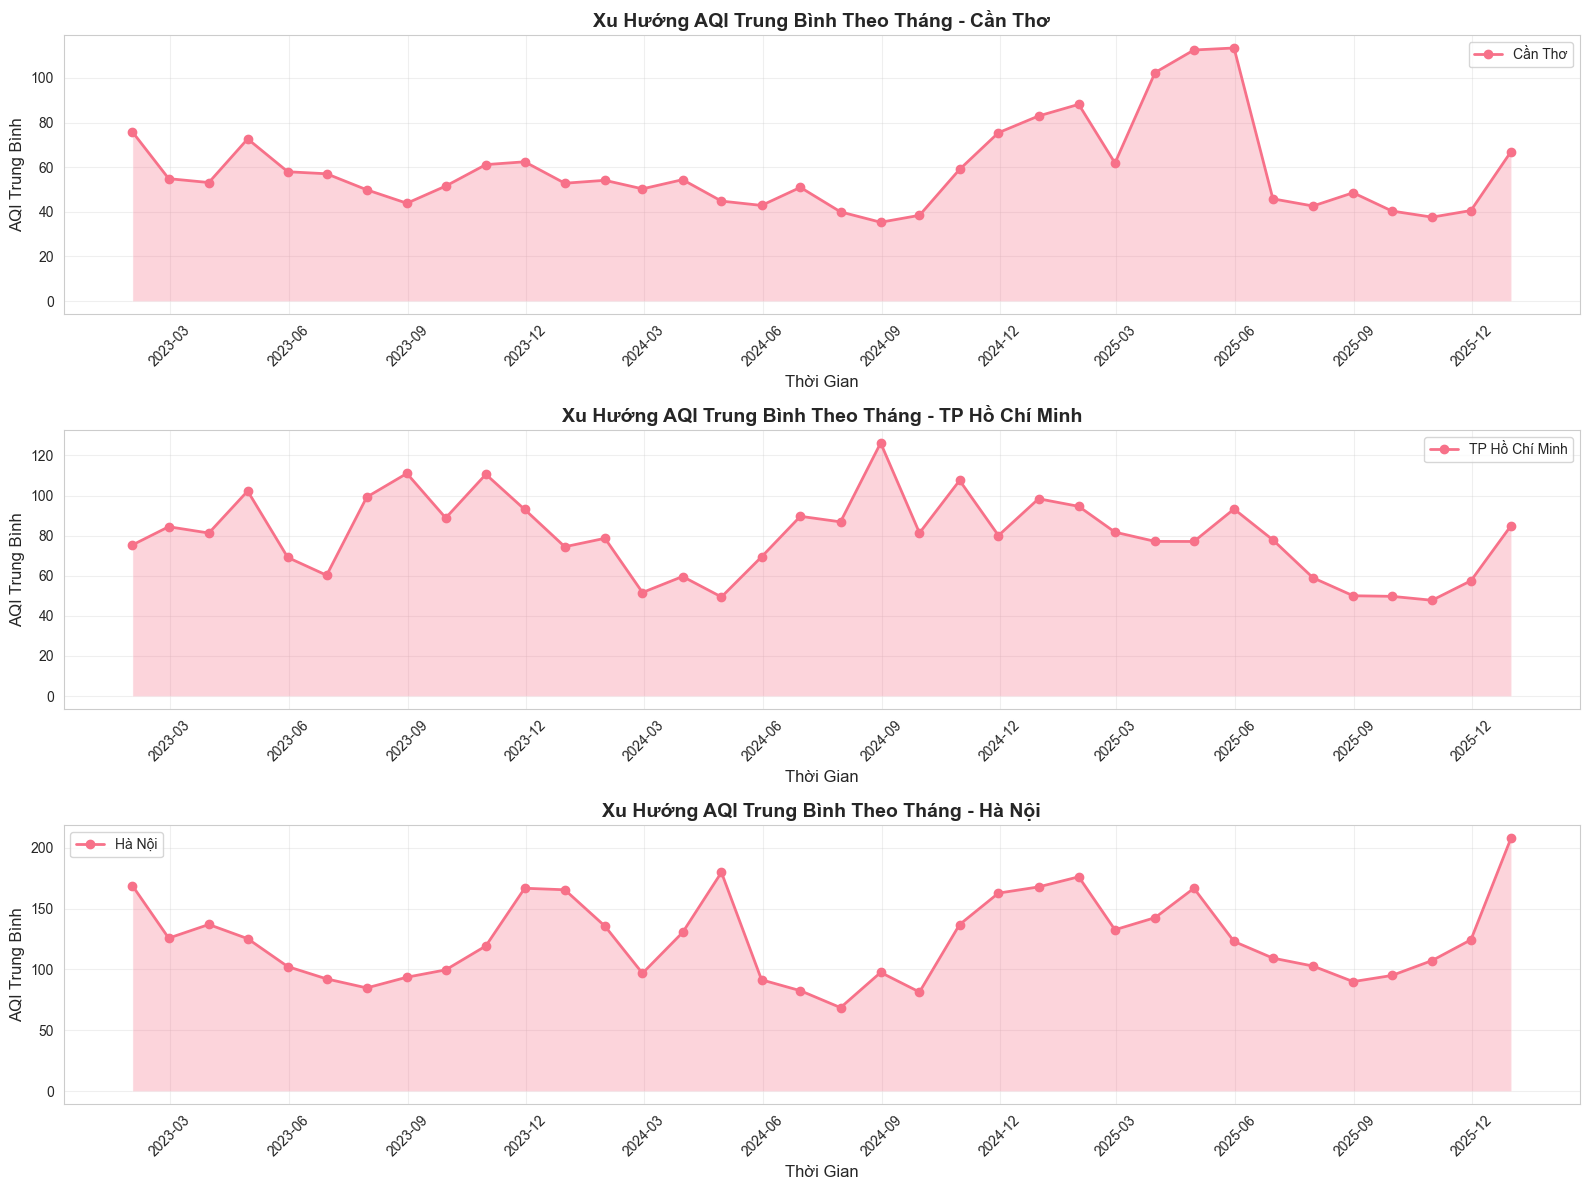

In [11]:
fig, axes = plt.subplots(len(data), 1, figsize=(16, 4 * len(data)))
if len(data) == 1:
    axes = [axes]

for idx, (city_name, df) in enumerate(data.items()):
    # Tính AQI trung bình theo tháng
    monthly_aqi = df['aqi'].resample('M').mean()

    axes[idx].plot(monthly_aqi.index, monthly_aqi.values, marker='o',
                    linewidth=2, markersize=6, label=city_name)
    axes[idx].fill_between(monthly_aqi.index, monthly_aqi.values, alpha=0.3)

    axes[idx].set_title(f'Xu Hướng AQI Trung Bình Theo Tháng - {city_name}',
                         fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('AQI Trung Bình', fontsize=12)
    axes[idx].set_xlabel('Thời Gian', fontsize=12)
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=10)

    # Format trục thời gian
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### 5.2. Phân Tích Theo Mùa

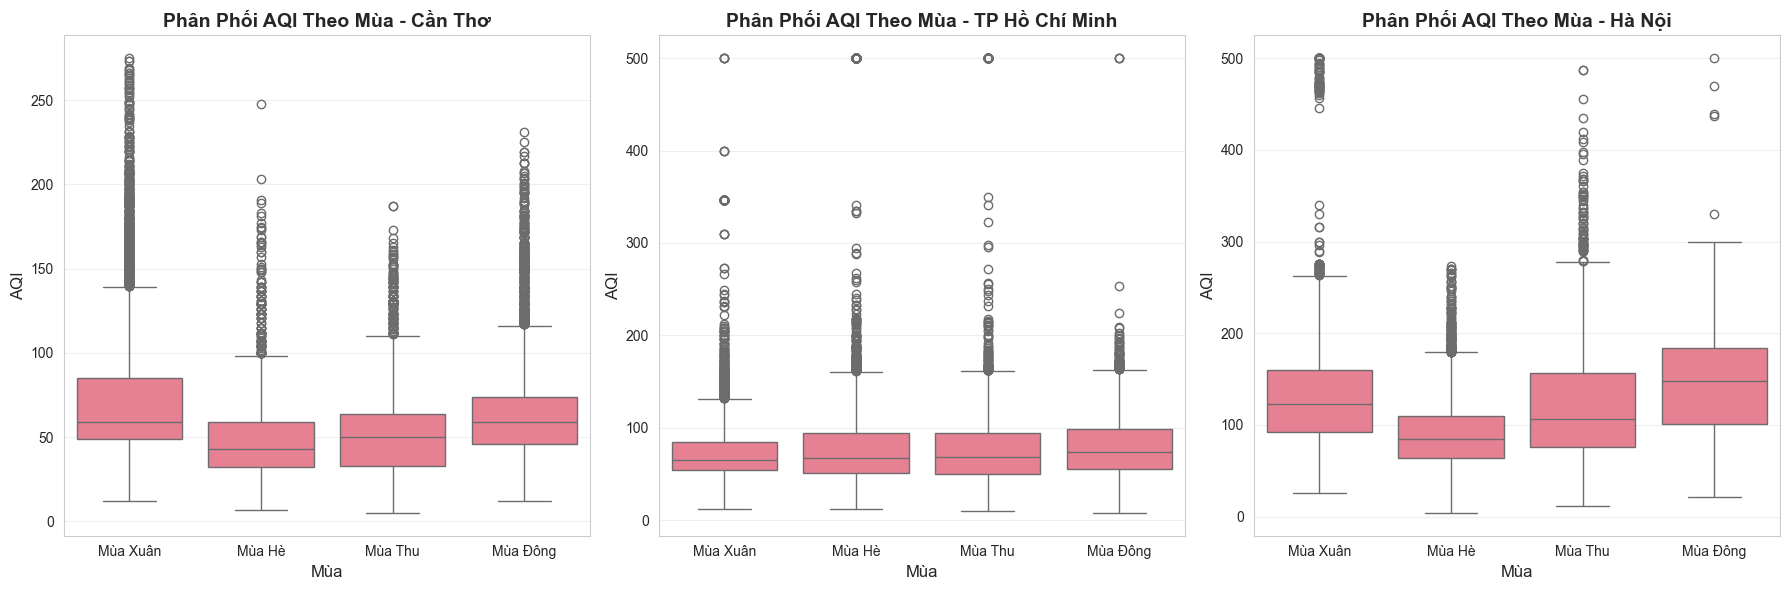


THỐNG KÊ AQI THEO MÙA - Cần Thơ
           mean    std   min    max
Mùa                                
Mùa Hè    45.93  20.21   7.0  248.0
Mùa Thu   51.84  24.27   5.0  187.0
Mùa Xuân  72.64  40.76  12.0  275.0
Mùa Đông  65.39  29.35  12.0  231.0

THỐNG KÊ AQI THEO MÙA - TP Hồ Chí Minh
           mean    std   min    max
Mùa                                
Mùa Hè    84.55  66.97  12.0  500.0
Mùa Thu   79.70  56.91  10.0  500.0
Mùa Xuân  75.39  41.73  12.0  500.0
Mùa Đông  80.08  34.11   8.0  500.0

THỐNG KÊ AQI THEO MÙA - Hà Nội
            mean    std   min    max
Mùa                                 
Mùa Hè     91.17  36.38   4.0  273.0
Mùa Thu   121.43  58.47  12.0  487.0
Mùa Xuân  132.84  61.95  26.0  500.0
Mùa Đông  146.92  55.64  21.0  500.0


In [12]:
def get_season(month):
    """Phân loại mùa dựa trên tháng (khí hậu Việt Nam)"""
    if month in [12, 1, 2]:
        return 'Mùa Đông'
    elif month in [3, 4, 5]:
        return 'Mùa Xuân'
    elif month in [6, 7, 8]:
        return 'Mùa Hè'
    else:
        return 'Mùa Thu'

# Thêm cột mùa vào mỗi dataframe
for city_name in data:
    data[city_name]['Mùa'] = data[city_name].index.month.map(get_season)

# Vẽ boxplot theo mùa
fig, axes = plt.subplots(1, len(data), figsize=(6 * len(data), 6))
if len(data) == 1:
    axes = [axes]

for idx, (city_name, df) in enumerate(data.items()):
    season_order = ['Mùa Xuân', 'Mùa Hè', 'Mùa Thu', 'Mùa Đông']
    sns.boxplot(data=df, x='Mùa', y='aqi', order=season_order, ax=axes[idx])

    axes[idx].set_title(f'Phân Phối AQI Theo Mùa - {city_name}',
                         fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('AQI', fontsize=12)
    axes[idx].set_xlabel('Mùa', fontsize=12)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê theo mùa
for city_name, df in data.items():
    print(f"\nTHỐNG KÊ AQI THEO MÙA - {city_name}")
    print("=" * 60)
    seasonal_stats = df.groupby('Mùa')['aqi'].agg(['mean', 'std', 'min', 'max'])
    print(seasonal_stats.round(2))

### 5.3. Biến Động Theo Giờ Trong Ngày

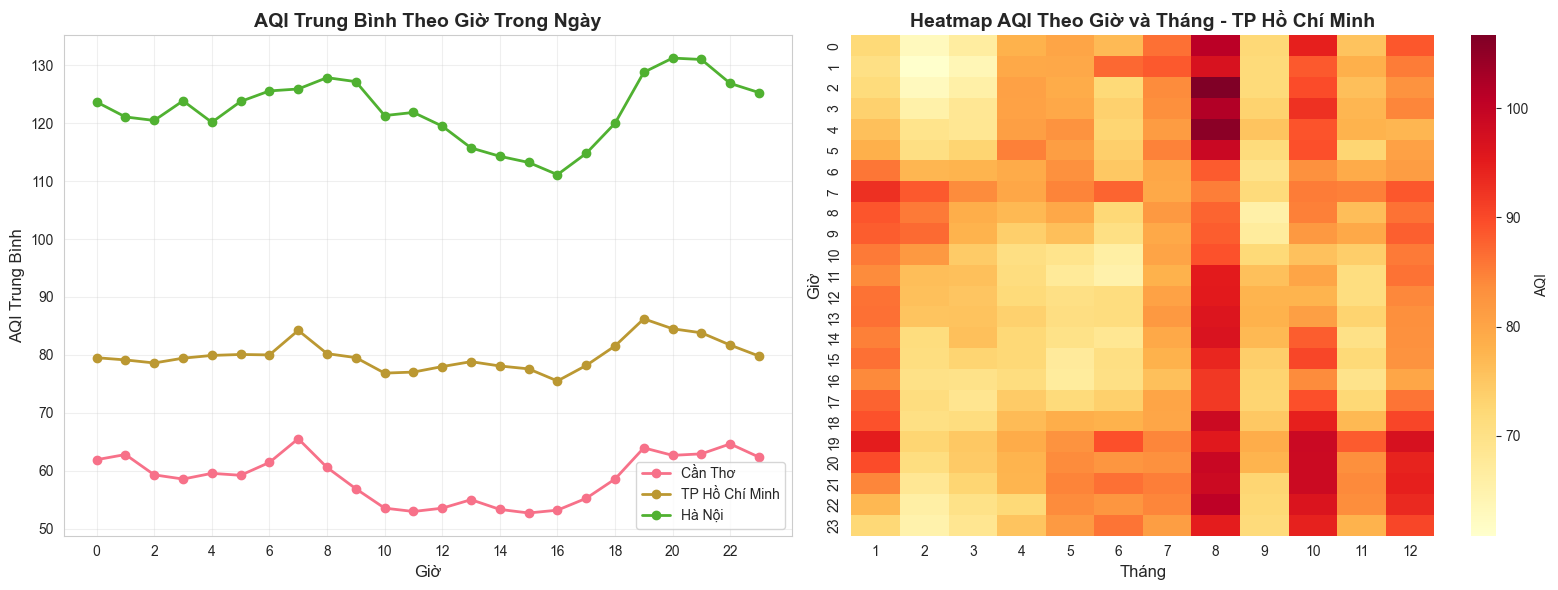

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ 1: AQI trung bình theo giờ
for city_name, df in data.items():
    hourly_aqi = df.groupby(df.index.hour)['aqi'].mean()
    axes[0].plot(hourly_aqi.index, hourly_aqi.values, marker='o',
                 linewidth=2, markersize=6, label=city_name)

axes[0].set_title('AQI Trung Bình Theo Giờ Trong Ngày', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Giờ', fontsize=12)
axes[0].set_ylabel('AQI Trung Bình', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Biểu đồ 2: Heatmap AQI theo giờ và tháng
if sample_city:
    df_sample = data[sample_city]
    df_sample['Giờ'] = df_sample.index.hour
    df_sample['Tháng'] = df_sample.index.month

    pivot_table = df_sample.pivot_table(values='aqi', index='Giờ',
                                         columns='Tháng', aggfunc='mean')

    sns.heatmap(pivot_table, cmap='YlOrRd', annot=False, fmt='.0f',
                cbar_kws={'label': 'AQI'}, ax=axes[1])
    axes[1].set_title(f'Heatmap AQI Theo Giờ và Tháng - {sample_city}',
                       fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Tháng', fontsize=12)
    axes[1].set_ylabel('Giờ', fontsize=12)

plt.tight_layout()
plt.show()

---

## 6. Phân Tích Đặc Trưng Gió

### 6.1. Biểu Đồ Hoa Gió (Wind Rose)

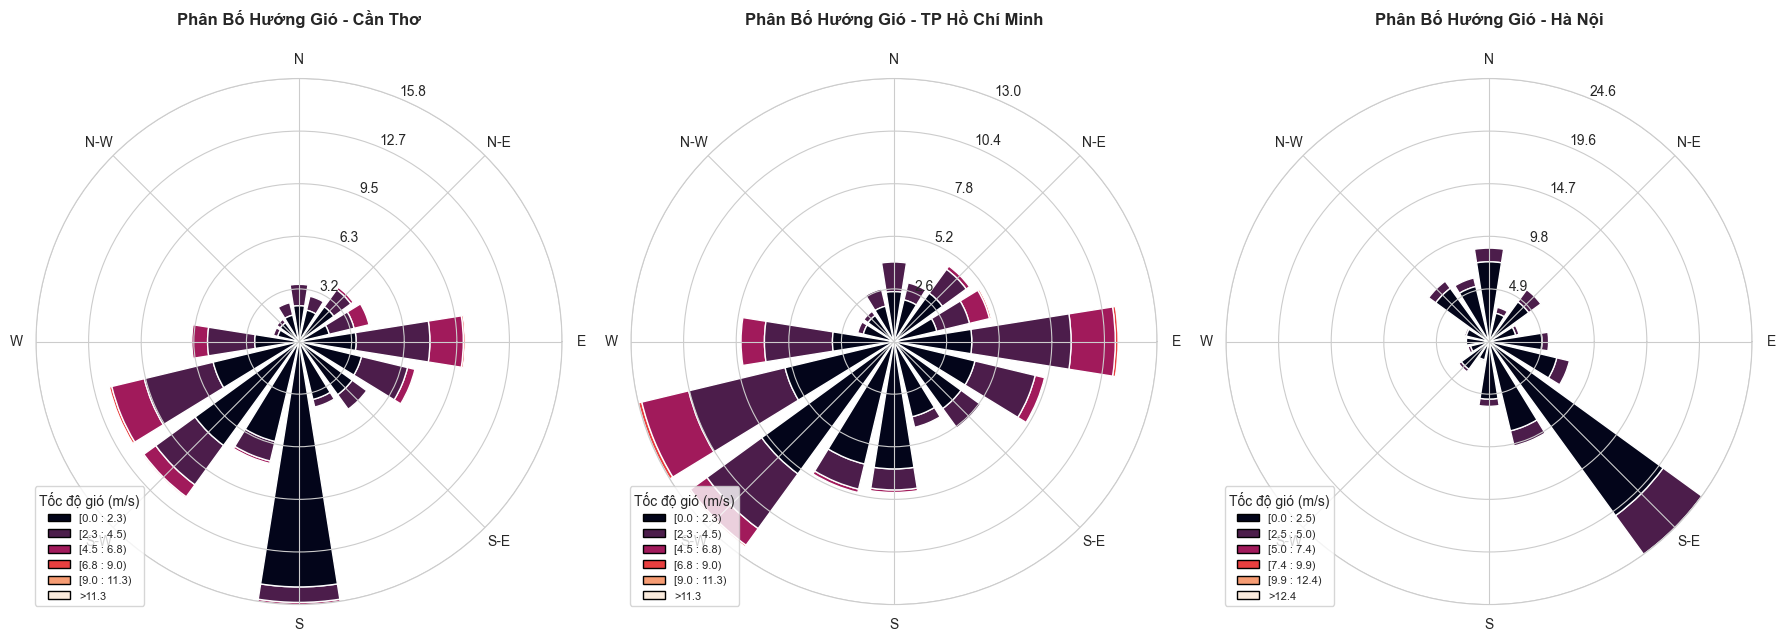

In [14]:
fig = plt.figure(figsize=(18, 6))

for idx, (city_name, df) in enumerate(data.items(), 1):
    # Lấy mẫu dữ liệu để vẽ nhanh hơn
    sample_size = min(10000, len(df))
    sample_df = df.sample(n=sample_size, random_state=42)

    ax = fig.add_subplot(1, len(data), idx, projection='windrose')
    ax.bar(sample_df['wind_dir'], sample_df['wind_spd'],
           normed=True, opening=0.8, edgecolor='white')
    ax.set_title(f'Phân Bố Hướng Gió - {city_name}', fontsize=12, fontweight='bold', pad=20)
    ax.set_legend(title='Tốc độ gió (m/s)', fontsize=8)

plt.tight_layout()
plt.show()

### 6.2. Mối Quan Hệ Giữa Gió và Ô Nhiễm

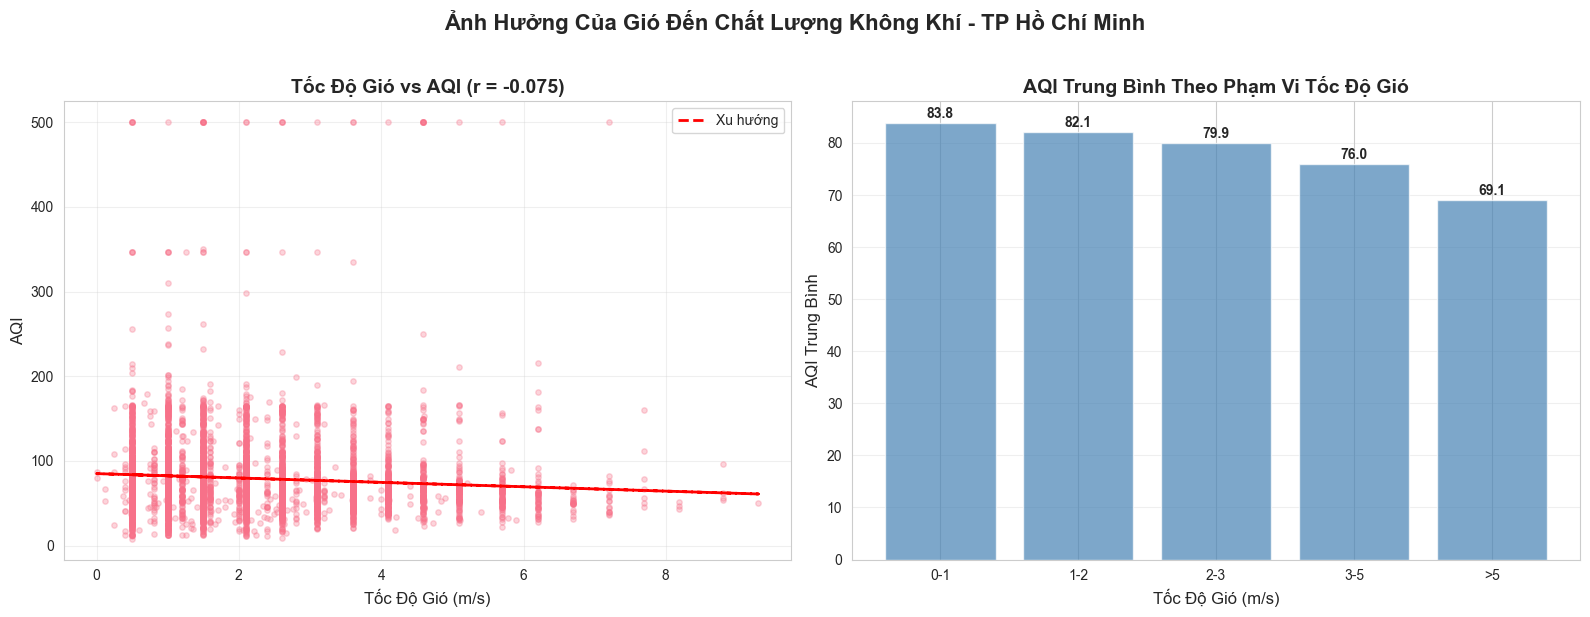

In [15]:
if sample_city:
    df_sample = data[sample_city]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Biểu đồ 1: Tốc độ gió vs AQI
    sample_indices = np.random.choice(len(df_sample), 5000, replace=False)
    x = df_sample['wind_spd'].iloc[sample_indices]
    y = df_sample['aqi'].iloc[sample_indices]

    axes[0].scatter(x, y, alpha=0.3, s=15)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[0].plot(x, p(x), "r--", linewidth=2, label='Xu hướng')

    corr, _ = pearsonr(x, y)
    axes[0].set_title(f'Tốc Độ Gió vs AQI (r = {corr:.3f})', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tốc Độ Gió (m/s)', fontsize=12)
    axes[0].set_ylabel('AQI', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)

    # Biểu đồ 2: AQI trung bình theo phạm vi tốc độ gió
    df_sample['wind_bin'] = pd.cut(df_sample['wind_spd'],
                                     bins=[0, 1, 2, 3, 5, 12],
                                     labels=['0-1', '1-2', '2-3', '3-5', '>5'])

    wind_aqi = df_sample.groupby('wind_bin')['aqi'].mean()
    axes[1].bar(range(len(wind_aqi)), wind_aqi.values, color='steelblue', alpha=0.7)
    axes[1].set_xticks(range(len(wind_aqi)))
    axes[1].set_xticklabels(wind_aqi.index)
    axes[1].set_title('AQI Trung Bình Theo Phạm Vi Tốc Độ Gió', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Tốc Độ Gió (m/s)', fontsize=12)
    axes[1].set_ylabel('AQI Trung Bình', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)

    # Thêm giá trị lên cột
    for i, v in enumerate(wind_aqi.values):
        axes[1].text(i, v + 1, f'{v:.1f}', ha='center', fontsize=10, fontweight='bold')

    plt.suptitle(f'Ảnh Hưởng Của Gió Đến Chất Lượng Không Khí - {sample_city}',
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

---

## 7. Tóm Tắt Phân Tích

### 7.1. Kết Luận Chính

In [16]:
print("="*80)
print("TÓM TẮT KẾT QUẢ PHÂN TÍCH")
print("="*80)
print()

for city_name, df in data.items():
    print(f"\n{city_name.upper()}:")
    print("-" * 60)

    print(f"1. AQI trung bình: {df['aqi'].mean():.2f} \u00b1 {df['aqi'].std():.2f}")
    print(f"2. AQI tối đa ghi nhận: {df['aqi'].max():.0f}")
    print(f"3. % thời gian AQI > 100 (không tốt cho sức khỏe): {(df['aqi'] > 100).sum() / len(df) * 100:.2f}%")

    # Tương quan với thời tiết
    # Select only numeric columns for correlation calculation
    numeric_cols = df.select_dtypes(include=np.number).columns
    corr_with_aqi = df[numeric_cols].corr()['aqi'].sort_values(ascending=False)
    print(f"\n4. Yếu tố tương quan dương mạnh nhất với AQI: {corr_with_aqi.index[1]} ({corr_with_aqi.iloc[1]:.3f})")
    print(f"5. Yếu tố tương quan âm mạnh nhất với AQI: {corr_with_aqi.index[-1]} ({corr_with_aqi.iloc[-1]:.3f})")

    # Thống kê chất ô nhiễm
    print(f"\n6. PM2.5 trung bình: {df['pm25'].mean():.2f} \u00b5g/m\u00b3")
    print(f"7. PM10 trung bình: {df['pm10'].mean():.2f} \u00b5g/m\u00b3")

print("\n" + "="*80)
print("HOÀN TẤT PHÂN TÍCH")
print("="*80)

TÓM TẮT KẾT QUẢ PHÂN TÍCH


CẦN THƠ:
------------------------------------------------------------
1. AQI trung bình: 58.75 ± 31.56
2. AQI tối đa ghi nhận: 275
3. % thời gian AQI > 100 (không tốt cho sức khỏe): 7.98%

4. Yếu tố tương quan dương mạnh nhất với AQI: pm25 (0.953)
5. Yếu tố tương quan âm mạnh nhất với AQI: wind_spd (-0.214)

6. PM2.5 trung bình: 16.67 µg/m³
7. PM10 trung bình: 30.67 µg/m³

TP HỒ CHÍ MINH:
------------------------------------------------------------
1. AQI trung bình: 79.93 ± 52.12
2. AQI tối đa ghi nhận: 500
3. % thời gian AQI > 100 (không tốt cho sức khỏe): 20.36%

4. Yếu tố tương quan dương mạnh nhất với AQI: pm25 (0.801)
5. Yếu tố tương quan âm mạnh nhất với AQI: wind_sin (-0.086)

6. PM2.5 trung bình: 30.18 µg/m³
7. PM10 trung bình: 45.27 µg/m³

HÀ NỘI:
------------------------------------------------------------
1. AQI trung bình: 122.29 ± 57.69
2. AQI tối đa ghi nhận: 500
3. % thời gian AQI > 100 (không tốt cho sức khỏe): 57.08%

4. Yếu tố tương quan d